# Исследовательский анализ данных и проверка гипотез

- Автор: Карпов Максим
- Дата: 29 июля 2025

### Цели и задачи проекта

Произвести анализ данных сервиса Яндекс Афиша и сделать выводы об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезу о разнице в поведении пользователей с мобильных и стационарных устройств.

### Описание данных

final_tickets_orders_df.csv - файл информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение `нет`.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например `mobile` для мобильных устройств, `desktop` для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - оличеством дней с предыдущей покупки для каждого пользователя.

final_tickets_events_df - файл содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 

- `event_id` — уникальный идентификатор мероприятия.  
- `event_name` — название мероприятия. Аналог поля `event_name_code` из исходной базы данных.  
- `event_type_description` — описание типа мероприятия.  
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.  
- `organizers` — организаторы мероприятия.  
- `region_name` — название региона.  
- `city_name` — название города.  
- `venue_id` — уникальный идентификатор площадки.  
- `venue_name` — название площадки.  
- `venue_address` — адрес площадки.  


final_tickets_tenge_df.csv - файл содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.
- `nominal` — номинал (100 тенге).  
- `data` — дата.  
- `curs` — курс тенге к рублю.  
- `cdx` — обозначение валюты (kzt).  


### Содержимое проекта



1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных.
4. Статистический анализ данных.
5. Общий вывод и рекомендации.



---

## 1. Загрузка данных и знакомство с ними

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
# Загружаем данные из CSV файлов
tickets_orders = pd.read_csv('/Users/maksimkoruhin/Downloads/final_tickets_orders_df.csv')
tickets_events = pd.read_csv('/Users/maksimkoruhin/Downloads/final_tickets_events_df.csv')
tickets_tenge = pd.read_csv('/Users/maksimkoruhin/Downloads/final_tickets_tenge_df.csv')

In [4]:
# Функция для автоматического осмотра данных
def lookup_datasets(dfs, filenames=None):
    """
    Выводит информацию о датасетах из списка

    Parameters:
        dfs (list of pd.DataFrame): Список датафреймов для обработки.
        filenames (list of str): Список названий файлов (имена для отображения).
    """
    if filenames is None:
        filenames = [f"df_{i + 1}" for i in range(len(dfs))]

    for df, df_name in zip(dfs, filenames):
        print('-'*10, ' '*5, df_name, ' '*5, '-'*10)

        # Пропущенные значения
        missing_data = df.isna().mean()
        missing_data_result = missing_data.apply(lambda x: f'{x:.2%}' if x > 0 else "")
        missing_data_name = "Пропущено" if missing_data.sum() > 0 else ""
        missing_data_result.name = missing_data_name

        # Типы данных
        dtypes_result = df.dtypes
        dtypes_result.name = "Тип данных колонки"
        fewest_nans_row = df.iloc[1:-1].isna().sum(axis=1).idxmin()

        values_type = df.loc[fewest_nans_row].map(type).T
        values_type.name = "Тип значения"

        # Проверка на полные дубликаты
        is_duplicate = df.duplicated(keep=False)
        duplicate_percentage = is_duplicate.mean()
        duplicate_info = pd.Series(
            ["Да" if val else "" for val in is_duplicate.iloc[[0, fewest_nans_row, -1]]],
            index=["Первая строка", "Типичная строка", "Последняя строка"],
            name="Дубликат"
        )

        # Объединяем результаты и примеры строк
        result = pd.concat([
            dtypes_result,                    # типы
            values_type,                     # типы значений
            missing_data_result,             # пропущенные значения
            df.iloc[0, :],                   # первая строка
            df.loc[fewest_nans_row].T,       # типичная строка
            df.iloc[-1, :],                  # последняя строка
        ], axis=1)

        result.columns = [
            "Тип данных", "Тип значения", missing_data_name or "Пропущено",
            "Первая строка", "Типичная строка", "Последняя строка"
        ]

        display(result)

        if duplicate_percentage > 0:
            print(f'Полных дубликатов: {duplicate_percentage:.2%}')
        else:
            print('Полных дубликатов не найдено.')

        print()

# Определяем словарь с датасетами
dfs = {
    "tickets_orders": tickets_orders,
    "tickets_events": tickets_events,
    "tickets_tenge": tickets_tenge
}

# Проводим автоматический осмотр данных
lookup_datasets(dfs.values(), dfs.keys())


----------       tickets_orders       ----------


,Тип данных,Тип значения,Пропущено,Первая строка,Типичная строка,Последняя строка
order_id,int64,<class 'numpy.int64'>,,4359165,7292370,813654
user_id,object,<class 'str'>,,0002849b70a3ce2,0005ca5e93f2cf4,ffff00725179321
created_dt_msk,object,<class 'str'>,,2024-08-20,2024-10-06,2024-09-25
created_ts_msk,object,<class 'str'>,,2024-08-20 16:08:03,2024-10-06 13:56:02,2024-09-25 15:12:40
event_id,int64,<class 'numpy.int64'>,,169230,578454,284965
cinema_circuit,object,<class 'str'>,,нет,нет,нет
age_limit,int64,<class 'numpy.int64'>,,16,0,16
currency_code,object,<class 'str'>,,rub,rub,rub
device_type_canonical,object,<class 'str'>,,mobile,mobile,mobile
revenue,float64,<class 'numpy.float64'>,,1521.94,1258.57,802.25


Полных дубликатов не найдено.

----------       tickets_events       ----------


,Тип данных,Тип значения,Пропущено,Первая строка,Типичная строка,Последняя строка
event_id,int64,<class 'numpy.int64'>,,4436,5785,592325
event_name,object,<class 'str'>,,e4f26fba-da77-4c61-928a-6c3e434d793f,5cc08a60-fdea-4186-9bb2-bffc3603fb77,f4952452-27ff-4d03-9adb-f7836430f83b
event_type_description,object,<class 'str'>,,спектакль,спектакль,событие
event_type_main,object,<class 'str'>,,театр,театр,другое
organizers,object,<class 'str'>,,№4893,№1931,№3884
region_name,object,<class 'str'>,,Североярская область,Светополянский округ,Яблоневская область
city_name,object,<class 'str'>,,Озёрск,Глиноград,Светополье
city_id,int64,<class 'numpy.int64'>,,2,54,39
venue_id,int64,<class 'numpy.int64'>,,1600,2196,1081
venue_name,object,<class 'str'>,,"Кладбище искусств ""Проблема"" и партнеры","Лекции по искусству ""Свет"" Групп","Искусственная сцена ""Краски"" и партнеры"


Полных дубликатов не найдено.

----------       tickets_tenge       ----------


,Тип данных,Тип значения,Пропущено,Первая строка,Типичная строка,Последняя строка
data,object,<class 'str'>,,2024-01-10,2024-01-11,2024-12-31
nominal,int64,<class 'numpy.int64'>,,100,100,100
curs,float64,<class 'numpy.float64'>,,19.9391,19.7255,19.486
cdx,object,<class 'str'>,,kzt,kzt,kzt


Полных дубликатов не найдено.



## 2. Предобработка данных и подготовка их к исследованию

### Вывод

На основе предоставленных данных можно сделать следующие выводы:

1. **tickets_orders**:
    - Содержит 290849 строк и 14 столбцов.
    - Присутствуют пропущенные значения в столбце `days_since_prev`.
    - Данные включают информацию о заказах билетов, таких как идентификаторы, даты, устройства, выручка и т.д.

2. **tickets_events**:
    - Содержит 22427 строк и 11 столбцов.
    - Все значения заполнены, пропущенных данных нет.
    - Данные включают информацию о мероприятиях, таких как название, тип, организаторы, регион, город и площадка.

3. **tickets_tenge**:
    - Содержит 357 строк и 4 столбца.
    - Все значения заполнены, пропущенных данных нет.
    - Данные включают информацию о курсе тенге к рублю за 2024 год.

---

### Шаги для предобработки данных


1. **Проверка на дубликаты**:
    - Проверить все датасеты на наличие полных и неполных дубликатов и удалить их, если они есть.

2. **Проверка на выбросы**:
    - Провести анализ на выбросы в числовых столбцах, таких как `revenue`, `tickets_count`, `total`, `curs`.

3. **Обогащение данных**:
    - При необходимости объединить данные из разных таблиц, например, связать `tickets_orders` с `tickets_events` по `event_id`.


---

### 2.1 Проверяем значения в ключевых столбцах

In [5]:
# Категориальные значения 
print("Категориальные значения в tickets_orders:")
print(tickets_orders['device_type_canonical'].unique())
print("Категориальные значения в tickets_events:")
print(tickets_events['event_type_description'].unique())
print(tickets_events['event_type_main'].unique())
print(tickets_orders['age_limit'].unique())

Категориальные значения в tickets_orders:
['mobile' 'desktop']
Категориальные значения в tickets_events:
['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']
['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']
[16  0 18 12  6]


In [6]:
# Выводим распределение типов событий
print("Распределение типов событий в tickets_events:")
display(tickets_events['event_type_main'].value_counts())

Распределение типов событий в tickets_events:


event_type_main
концерты    8680
театр       7076
другое      4658
спорт        872
стендап      636
выставки     290
ёлки         215
Name: count, dtype: int64

Значение `другое` в основном типе мероприятия (`event_type_main`) обычно используется для обозначения событий, которые не попадают в заранее определённые категории. Это может включать:

- Уникальные или редкие мероприятия: События, которые не имеют аналогов или происходят редко.
- Многожанровые мероприятия: События, которые сочетают в себе элементы нескольких категорий.
- Неопределённые данные: Если организаторы не предоставили точную информацию о типе мероприятия.

In [7]:
# Количественные значения 
# Делим на 2 группы по currency_code 
grouped_rub = tickets_orders[tickets_orders['currency_code'] == 'rub']
grouped_tenge = tickets_orders[tickets_orders['currency_code'] == 'kzt']

In [8]:
# Описательная статистика для revenue по валютам
print("Описательная статистика для `revenue` в рублях (RUB):")
print(grouped_rub['revenue'].describe(), "\n")

print("Описательная статистика для `revenue` в тенге (KZT):")
print(grouped_tenge['revenue'].describe())

Описательная статистика для `revenue` в рублях (RUB):
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64 

Описательная статистика для `revenue` в тенге (KZT):
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


In [9]:
# Описательная статистика для tickets_count по валютам
print("\nОписательная статистика для `tickets_count` в рублях (RUB):")
print(grouped_rub['tickets_count'].describe(), "\n")
print("Описательная статистика для `tickets_count` в тенге (KZT):")
print(grouped_tenge['tickets_count'].describe())



Описательная статистика для `tickets_count` в рублях (RUB):
count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64 

Описательная статистика для `tickets_count` в тенге (KZT):
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/204254733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tickets_orders, x='currency_code', y='revenue', palette='Set1')


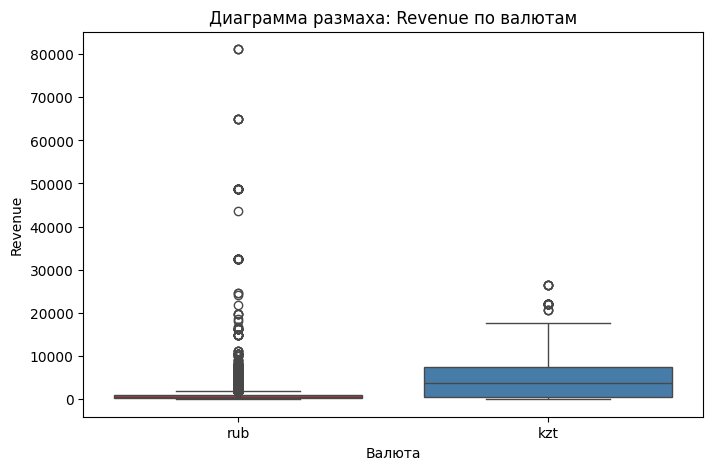

/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/204254733.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tickets_orders, x='currency_code', y='tickets_count', palette='Set1')


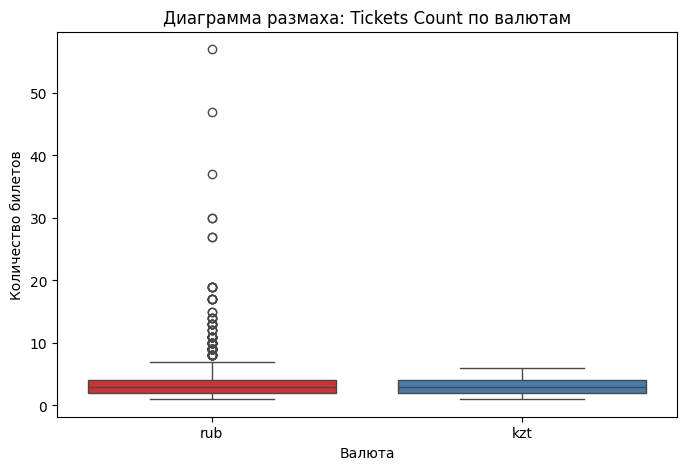

In [10]:
# Диаграмма для revenue по валютам
plt.figure(figsize=(8, 5))
sns.boxplot(data=tickets_orders, x='currency_code', y='revenue', palette='Set1')
plt.title('Диаграмма размаха: Revenue по валютам')
plt.xlabel('Валюта')
plt.ylabel('Revenue')
plt.show()

# Диаграмма для tickets_count по валютам
plt.figure(figsize=(8, 5))
sns.boxplot(data=tickets_orders, x='currency_code', y='tickets_count', palette='Set1')
plt.title('Диаграмма размаха: Tickets Count по валютам')
plt.xlabel('Валюта')
plt.ylabel('Количество билетов')
plt.show()


### Вывод по диаграммам

1. **Диаграмма размаха: Revenue по валютам**:
    - Выручка в рублях (RUB) имеет более широкий диапазон значений по сравнению с тенге (KZT).
    - В данных по рублям наблюдаются выбросы, что может свидетельствовать о наличии заказов с аномально высокой выручкой.
    - Выручка в тенге более сконцентрирована, что может указывать на меньшую вариативность цен.

2. **Диаграмма размаха: Tickets Count по валютам**:
    - Количество билетов в рублях (RUB) также имеет больший разброс значений.
    - В данных по тенге (KZT) количество билетов более равномерное, с меньшим количеством выбросов.
    - Это может быть связано с различиями в ценовой политике или популярности мероприятий в разных валютах.

In [11]:
# 1. Квантили по rub
revenue_99_rub = tickets_orders[tickets_orders['currency_code'] == 'rub']['revenue'].quantile(0.99)
tickets_count_99_rub = tickets_orders[tickets_orders['currency_code'] == 'rub']['tickets_count'].quantile(0.99)

# 2. Комбинированная фильтрация
df_filtered = tickets_orders[
    (tickets_orders['currency_code'] != 'rub') |
    (
        (tickets_orders['currency_code'] == 'rub') &
        (tickets_orders['revenue'] <= revenue_99_rub) &
        (tickets_orders['tickets_count'] <= tickets_count_99_rub)
    )
]



/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/1343807664.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='currency_code', y='revenue', palette='Set1')


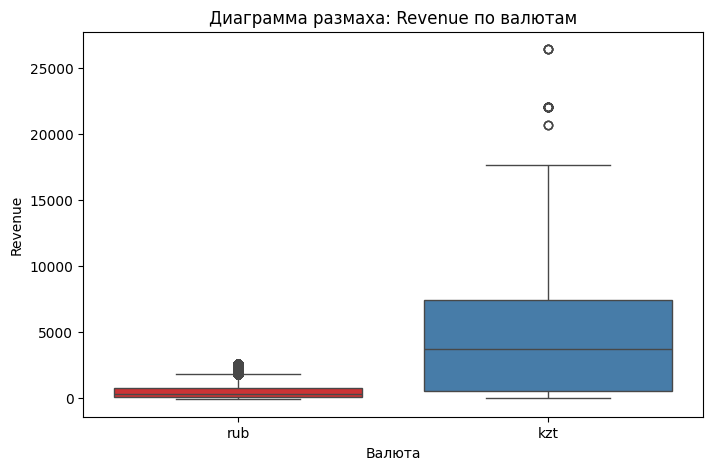

In [12]:
# Диаграмма для revenue по валютам
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x='currency_code', y='revenue', palette='Set1')
plt.title('Диаграмма размаха: Revenue по валютам')
plt.xlabel('Валюта')
plt.ylabel('Revenue')  
plt.show()

/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/3540548417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='currency_code', y='tickets_count', palette='Set1')


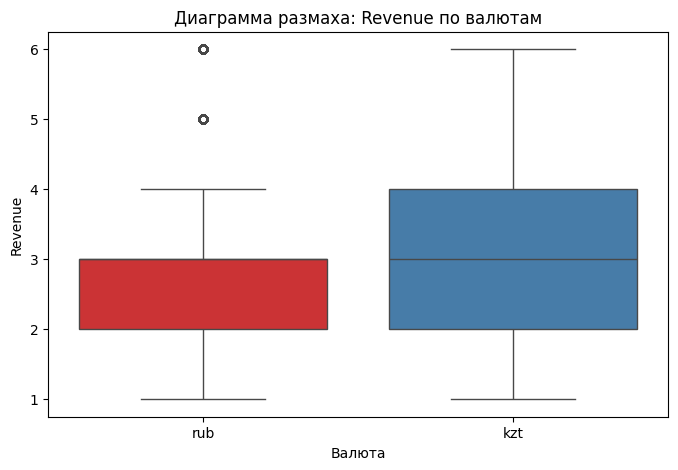

In [13]:
# Диаграмма для revenue по валютам
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x='currency_code', y='tickets_count', palette='Set1')
plt.title('Диаграмма размаха: Revenue по валютам')
plt.xlabel('Валюта')
plt.ylabel('Revenue')
plt.show()

### 2.2 Проверка на неявные дубликаты


In [14]:
# Проверяем неявные дубликаты без учёта order_id
columns_to_check = df_filtered.columns.difference(['order_id'])
implicit_duplicates = df_filtered.duplicated(subset=columns_to_check, keep=False)

# Отбираем строки с неявными дубликатами
implicit_duplicates_orders = df_filtered[implicit_duplicates]

# Выводим результат
print(f"Количество неявных дубликатов: {implicit_duplicates_orders.shape[0]}")
display(implicit_duplicates_orders.head())

Количество неявных дубликатов: 58


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0


In [15]:
# Удаляем неявные дубликаты, оставляя первую запись
tickets_orders_cleaned = df_filtered.drop_duplicates(subset=columns_to_check, keep='first')
print(f"Количество строк после удаления дубликатов: {tickets_orders_cleaned.shape[0]}")

Количество строк после удаления дубликатов: 287781


### 2.3 Преобразование типов данных

In [16]:
# Преобразуем в тип datetime
tickets_orders_cleaned['created_dt_msk'] = pd.to_datetime(tickets_orders_cleaned['created_dt_msk']).dt.normalize()

# Преобразуем в datetime
tickets_orders_cleaned['created_ts_msk'] = pd.to_datetime(tickets_orders_cleaned['created_ts_msk'])

display(tickets_orders_cleaned.info())
display(tickets_orders_cleaned[[ 'created_dt_msk', 'created_ts_msk']].head())


<class 'pandas.core.frame.DataFrame'>
Index: 287781 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               287781 non-null  int64         
 1   user_id                287781 non-null  object        
 2   created_dt_msk         287781 non-null  datetime64[ns]
 3   created_ts_msk         287781 non-null  datetime64[ns]
 4   event_id               287781 non-null  int64         
 5   cinema_circuit         287781 non-null  object        
 6   age_limit              287781 non-null  int64         
 7   currency_code          287781 non-null  object        
 8   device_type_canonical  287781 non-null  object        
 9   revenue                287781 non-null  float64       
 10  service_name           287781 non-null  object        
 11  tickets_count          287781 non-null  int64         
 12  total                  287781 non-null  float64  

/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/1684215353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_orders_cleaned['created_dt_msk'] = pd.to_datetime(tickets_orders_cleaned['created_dt_msk']).dt.normalize()
/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/1684215353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_orders_cleaned['created_ts_msk'] = pd.to_datetime(tickets_orders_cleaned['created_ts_msk'])


None

,created_dt_msk,created_ts_msk
0,2024-08-20,2024-08-20 16:08:03
1,2024-07-23,2024-07-23 18:36:24
2,2024-10-06,2024-10-06 13:56:02
3,2024-07-13,2024-07-13 19:40:48
4,2024-10-04,2024-10-04 22:33:15


###  Создаем новые столбцы 

In [17]:
# Преобразуем столбец 'data' в тип datetime
tickets_tenge['data'] = pd.to_datetime(tickets_tenge['data'])

# Объединяем датафреймы tickets_orders_cleaned и tickets_tenge по столбцу 'created_dt_msk' и 'data'
tickets_orders_cleaned = tickets_orders_cleaned.merge(
    tickets_tenge, 
    left_on='created_dt_msk', 
    right_on='data', 
    how='left'
)

In [18]:
# Выводим информацию о датафрейме после объединения
display(tickets_orders_cleaned.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,2024-10-04,100,19.6648,kzt


### Создаем столбец revenue_rub 

In [19]:
# Создаем столбец revenue_rub 
if 'revenue_rub' not in tickets_orders_cleaned.columns:
    tickets_orders_cleaned['revenue_rub'] = tickets_orders_cleaned.apply(
        lambda row: row['total'] * row['curs'] / 100 if row['currency_code'] == 'kzt' else row['total'],
        axis=1
    )
# Округляем revenue_rub до 2 знаков после запятой
tickets_orders_cleaned['revenue_rub'] = tickets_orders_cleaned['revenue_rub'].round(2)
# Проверяем, что столбец revenue_rub создан
tickets_orders_cleaned[tickets_orders_cleaned['currency_code']=='kzt'].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub
73,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.10,Билеты без проблем,4,10361.97,20.0,2024-09-17,100,19.0125,kzt,1970.07
91,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.18,Билеты без проблем,3,6943.61,39.0,2024-09-02,100,18.9330,kzt,1314.63
98,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.77,Билеты без проблем,4,10959.07,NaN,2024-09-09,100,18.5991,kzt,2038.29
286,720419,00f4f5244501ce6,2024-06-11,2024-06-11 20:15:57,536826,нет,12,kzt,mobile,22021.55,Мой билет,5,275269.40,NaN,2024-06-11,100,19.8928,kzt,54758.79
466,5227657,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:28:17,533803,нет,16,kzt,desktop,7397.66,Мой билет,4,123294.32,1.0,2024-06-04,100,19.9833,kzt,24638.27


In [20]:
# Создаем столбец one_ticket_revenue_rub с расчетом выручки на один билет
tickets_orders_cleaned['one_ticket_revenue_rub'] = tickets_orders_cleaned['revenue_rub'] / tickets_orders_cleaned['tickets_count']
# Округляем one_ticket_revenue_rub до 2 знаков после запятой
tickets_orders_cleaned['one_ticket_revenue_rub'] = tickets_orders_cleaned['one_ticket_revenue_rub'].round(2)
display(tickets_orders_cleaned.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,2024-08-20,100,18.6972,kzt,10870.99,2717.75
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,2024-07-23,100,18.3419,kzt,2067.51,1033.76
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,2024-10-06,100,19.6475,kzt,13984.16,3496.04
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2024-07-13,100,18.5010,kzt,212.28,106.14
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,2024-10-04,100,19.6648,kzt,10695.43,3565.14


In [21]:
# Создаем столбец month с месяцем заказа
tickets_orders_cleaned['month'] = tickets_orders_cleaned['created_dt_msk'].dt.strftime('%m')
# Проверяем, что столбец month создан
display(tickets_orders_cleaned.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,4,10870.99,NaN,2024-08-20,100,18.6972,kzt,10870.99,2717.75,08
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,2,2067.51,NaN,2024-07-23,100,18.3419,kzt,2067.51,1033.76,07
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,4,13984.16,75.0,2024-10-06,100,19.6475,kzt,13984.16,3496.04,10
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2,212.28,NaN,2024-07-13,100,18.5010,kzt,212.28,106.14,07
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,3,10695.43,83.0,2024-10-04,100,19.6648,kzt,10695.43,3565.14,10


In [22]:
# Создаем столбец season с сезоном заказа
def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'
tickets_orders_cleaned['season'] = tickets_orders_cleaned['month'].apply(get_season)
# Проверяем, что столбец season создан
display(tickets_orders_cleaned.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,10870.99,NaN,2024-08-20,100,18.6972,kzt,10870.99,2717.75,08,Лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,2067.51,NaN,2024-07-23,100,18.3419,kzt,2067.51,1033.76,07,Лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,13984.16,75.0,2024-10-06,100,19.6475,kzt,13984.16,3496.04,10,Осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,212.28,NaN,2024-07-13,100,18.5010,kzt,212.28,106.14,07,Лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10695.43,83.0,2024-10-04,100,19.6648,kzt,10695.43,3565.14,10,Осень


### Вывод по пункту 2: Предобработка данных и подготовка их к исследованию

1. **Проверка на дубликаты**:
    - Полные дубликаты в данных отсутствуют.
    - Найдены неявные дубликаты (58 строк), которые были удалены, оставив первую запись.

2. **Проверка на выбросы**:
    - Проведен анализ выбросов для столбцов `revenue` и `tickets_count` в рублях (RUB).
    - Данные были отфильтрованы по 99% квантилю, чтобы исключить аномальные значения.

3. **Преобразование типов данных**:
    - Столбцы `created_dt_msk`, `created_ts_msk` и `data` преобразованы в формат `datetime`.
    - Это позволило упростить работу с датами и временными метками.

4. **Создание новых столбцов**:
    - Добавлены столбцы:
        - `revenue_rub` — выручка в рублях, рассчитанная для заказов в тенге.
        - `one_ticket_revenue_rub` — выручка на один билет.
        - `month` — месяц заказа.
        - `season` — сезон заказа.
    - Эти столбцы помогут в дальнейшем анализе данных.

5. **Обогащение данных**:
    - Данные о заказах (`tickets_orders_cleaned`) объединены с данными о курсе тенге (`tickets_tenge`) по дате.
    - Это позволило учесть изменения курса валют при расчетах.

Итог: Данные очищены, преобразованы и дополнены новыми признаками, что делает их готовыми для дальнейшего анализа.

## 3. Исследовательский анализ данных

###  3.1. Анализ распределения заказов по сегментам и их сезонные изменения

,month,order_count
0,06,34355
1,07,40381
2,08,44538
3,09,69293
4,10,99214


/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/534638938.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=orders_by_month, x='month', y='order_count', palette='Set1')


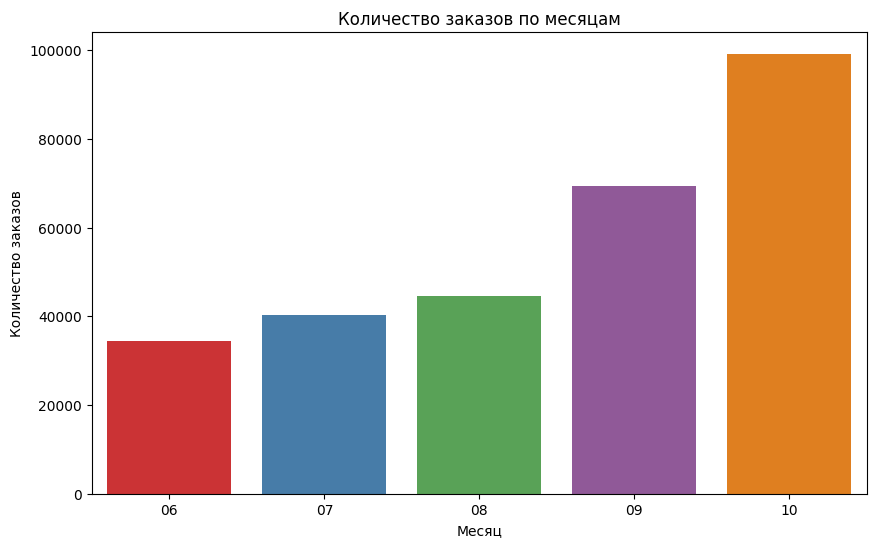

In [23]:
# Считаем количество заказов по месяцам 
orders_by_month = tickets_orders_cleaned.groupby('month').size().reset_index(name='order_count')
display(orders_by_month)
# Строим столбчатую диаграмму для количества заказов по месяцам
plt.figure(figsize=(10, 6))
sns.barplot(data=orders_by_month, x='month', y='order_count', palette='Set1')
plt.title('Количество заказов по месяцам')  
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()



1. **Рост количества заказов**:
    - Наблюдается значительный рост количества заказов с июня по октябрь.
    - Максимальное количество заказов приходится на октябрь.

2. **Сезонность**:
    - Летние месяцы (июнь, июль, август) демонстрируют стабильный рост заказов.
    - Осенние месяцы (сентябрь, октябрь) показывают пик активности, что может быть связано с увеличением числа мероприятий в этот период.


In [24]:
# Присоединяем данные о событиях к заказам
tickets_orders_cleaned = tickets_orders_cleaned.merge(
    tickets_events, 
    on='event_id',
    how='left')
# Проверяем, что данные о событиях присоединены
display(tickets_orders_cleaned.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


order_count  order_share
season event_type_main                          
Лето   выставки                2416     0.020293
       другое                 32302     0.271313
       концерты               50782     0.426532
       спорт                   3004     0.025231
       стендап                 6346     0.053302
       театр                  23935     0.201036
       ёлки                     273     0.002293
Осень  выставки                2436     0.014458
       другое                 33155     0.196783
       концерты               62684     0.372045
       спорт                  18870     0.111998
       стендап                 6923     0.041090
       театр                  42728     0.253601
       ёлки                    1689     0.010025

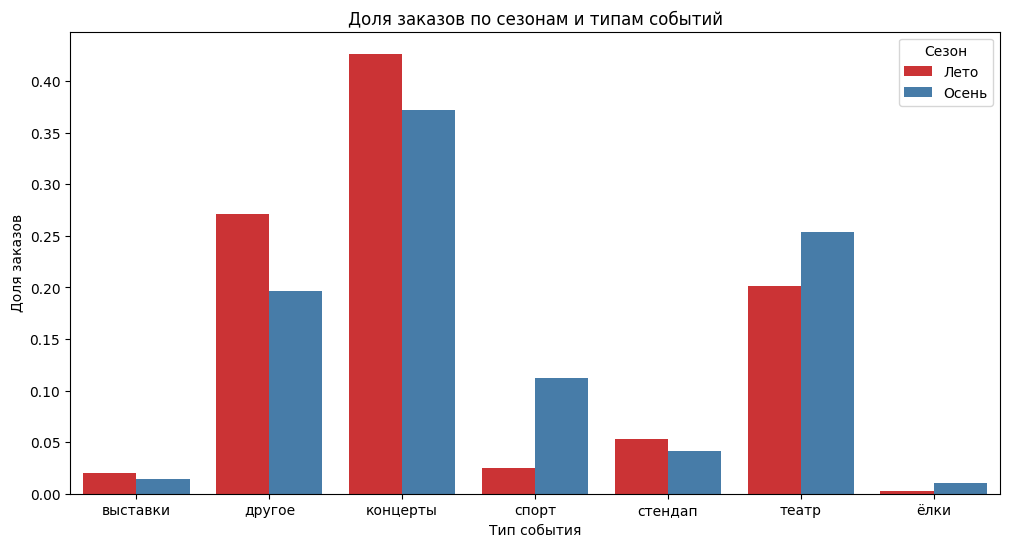

In [ ]:
# Считаем количество заказов по сезонам и типам событий
order_stats_by_season_event = tickets_orders_cleaned.groupby([ 'season','event_type_main' ]).agg({'order_id': 'count'}).rename(
    columns={'order_id': 'order_count'})
# Считаем доля заказов по сезонам и типам событий
order_stats_by_season_event['order_share'] = order_stats_by_season_event.groupby('season')['order_count'].transform(lambda x: x / x.sum())
display(order_stats_by_season_event)
# Строим столбчатую диаграмму для доли заказов по сезонам и типам событий
plt.figure(figsize=(12, 6))
sns.barplot(data=order_stats_by_season_event.reset_index(),
            x='event_type_main',
            y='order_share',
            hue='season',
            palette='Set1')
plt.title('Доля заказов по сезонам и типам событий')
plt.xlabel('Тип события')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
plt.show()

order_count  order_share
season device_type_canonical                          
Лето   desktop                      23091     0.193596
       mobile                       96183     0.806404
Осень  desktop                      34256     0.203291
       mobile                      134251     0.796709

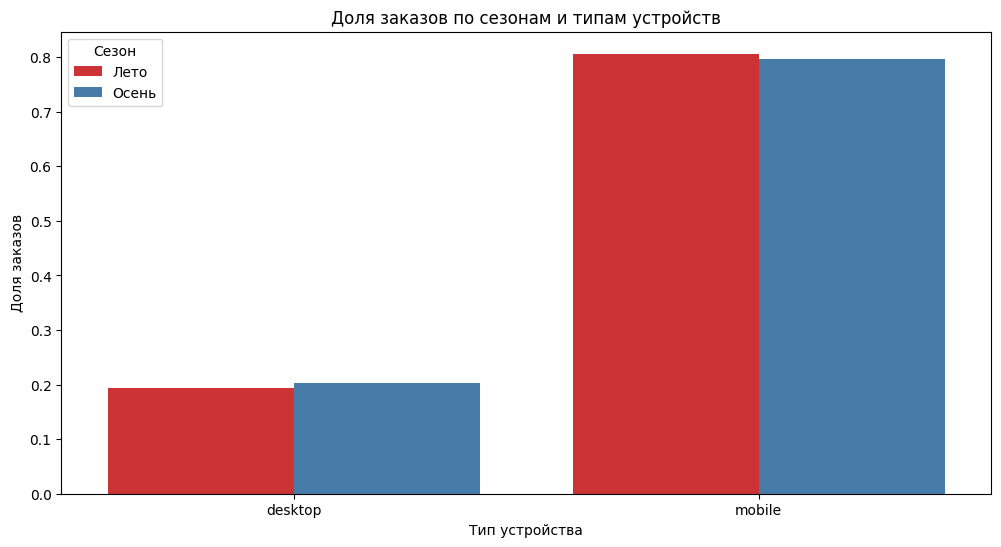

In [26]:
# Считаем количество заказов по сезонам и типам устройств
order_stats_by_season_device = tickets_orders_cleaned.groupby([ 'season','device_type_canonical' ]).agg({'order_id': 'count'}).rename(
    columns={'order_id': 'order_count'})
# Считаем доля заказов по сезонам и типам событий
order_stats_by_season_device['order_share'] = order_stats_by_season_device.groupby('season')['order_count'].transform(lambda x: x / x.sum())
display(order_stats_by_season_device)
# Строим столбчатую диаграмму для доли заказов по сезонам и типам устройств
plt.figure(figsize=(12, 6))
sns.barplot(data=order_stats_by_season_device.reset_index(),
            x='device_type_canonical',
            y='order_share',
            hue='season',
            palette='Set1')
plt.title('Доля заказов по сезонам и типам устройств')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
plt.show() 

order_count  order_share
season age_limit                          
Лето   0                21385     0.179293
       6                21679     0.181758
       12               24548     0.205812
       16               33769     0.283121
       18               17893     0.150016
Осень  0                39806     0.236228
       6                29703     0.176272
       12               37222     0.220893
       16               44217     0.262405
       18               17559     0.104203

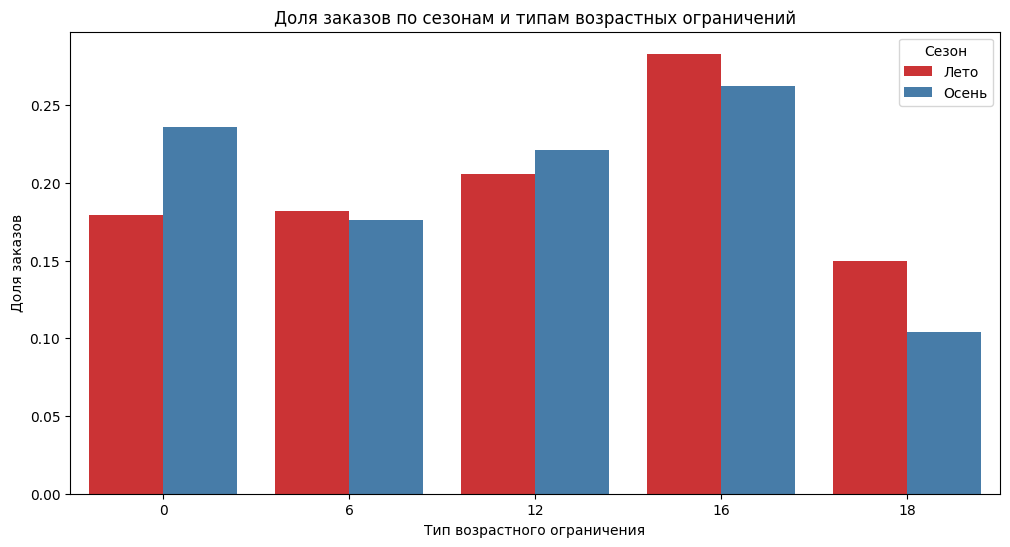

In [ ]:
# Считаем количество заказов по сезонам и типам возрастных ограничений
order_stats_by_season_age = tickets_orders_cleaned.groupby([ 'season','age_limit' ]).agg({'order_id': 'count'}).rename(
    columns={'order_id': 'order_count'})
# Считаем доля заказов по сезонам и типам событий
order_stats_by_season_age['order_share'] = order_stats_by_season_age.groupby('season')['order_count'].transform(lambda x: x / x.sum())
display(order_stats_by_season_age)
# Строим столбчатую диаграмму для доли заказов по сезонам и типам возрастных ограничений
plt.figure(figsize=(12, 6))
sns.barplot(data=order_stats_by_season_age.reset_index(),
            x='age_limit',
            y='order_share',
            hue='season',
            palette='Set1')
plt.title('Доля заказов по сезонам и типам возрастных ограничений')
plt.xlabel('Тип возрастного ограничения')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
plt.show()

,mean_revenue_summer,mean_revenue_autumn,relative_change
event_type_main,,,
выставки,851.581507,845.494918,-0.714739
другое,1370.520978,1389.462807,1.382090
концерты,3389.401030,2893.401856,-14.633830
спорт,749.586252,913.607503,21.881571
стендап,1903.546484,2130.730378,11.934770
театр,2466.342197,2100.952294,-14.815053
ёлки,2685.741099,2216.854630,-17.458364


/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/3071183176.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_revenue.reset_index(),


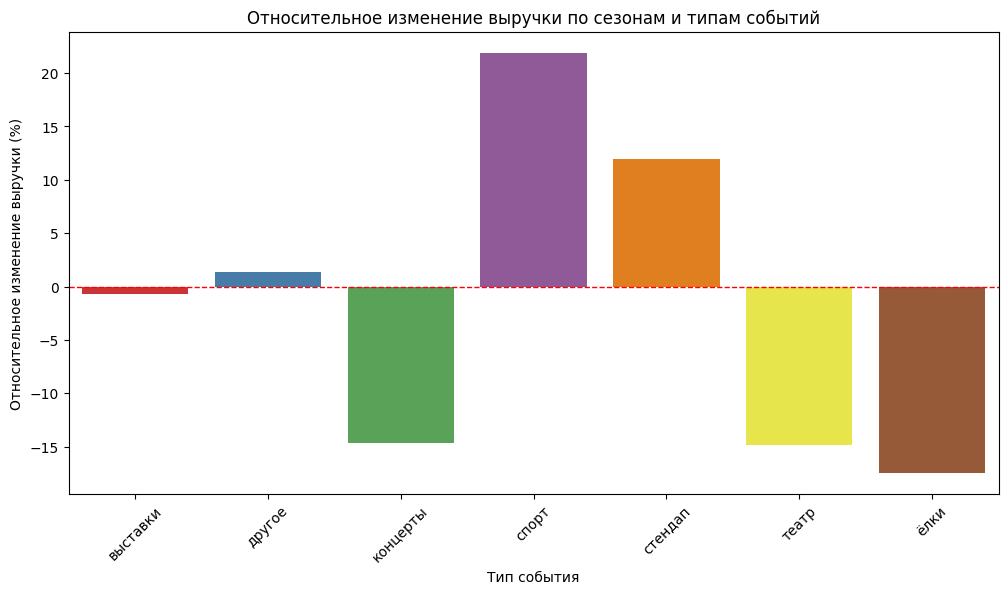

In [28]:
# Анализируем изменение выручки по сезонам и типам событий
summer_order_stats_revenue = tickets_orders_cleaned[tickets_orders_cleaned['season']=='Лето'].groupby( 'event_type_main').agg({'one_ticket_revenue_rub': 'mean'}).rename(
    columns={'one_ticket_revenue_rub': 'mean_revenue'})
autumn_order_stats_revenue = tickets_orders_cleaned[tickets_orders_cleaned['season']=='Осень'].groupby( 'event_type_main').agg({'one_ticket_revenue_rub': 'mean'}).rename(
    columns={'one_ticket_revenue_rub': 'mean_revenue'})
# Объединяем таблицы по индексу (event_type_main)
combined_revenue = summer_order_stats_revenue.join(
    autumn_order_stats_revenue, 
    lsuffix='_summer', 
    rsuffix='_autumn'
)

combined_revenue['relative_change'] = ((combined_revenue['mean_revenue_autumn'] - combined_revenue['mean_revenue_summer']) / combined_revenue['mean_revenue_summer'])*100
display(combined_revenue)
# Строим график для относительного изменения выручки
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_revenue.reset_index(),
            x='event_type_main',
            y='relative_change',
            palette='Set1')
plt.title('Относительное изменение выручки по сезонам и типам событий')
plt.xlabel('Тип события')
plt.ylabel('Относительное изменение выручки (%)')
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()




1. **Распределение заказов по категориям с наступлением осени**:
    - С наступлением осени наблюдается увеличение доли заказов на мероприятия категории "концерты" и "театр".
    - Доля заказов на "спорт" также значительно возрастает, что может быть связано с сезонными спортивными событиями.
    - Категория "ёлки" демонстрирует рост, что ожидаемо, так как осенью начинают готовиться к новогодним мероприятиям.
    - Доля заказов на "выставки" и "другое" остается относительно стабильной.

2. **Изменение средней стоимости одного билета**:
    - Средняя стоимость одного билета в категории "концерты" снизилась с наступлением осени.
    - В категориях "спорт" и "стендап" наблюдается рост средней стоимости билета.
    - Категории "театр" и "ёлки" демонстрируют снижение средней стоимости билета, что может быть связано с увеличением доступности или скидками.
    - Категория "другое" показывает небольшой рост средней стоимости билета.

### Общий вывод:
С наступлением осени меняется структура спроса на мероприятия: увеличивается популярность концертов, театров и спортивных событий. При этом средняя стоимость билетов варьируется в зависимости от категории, что может быть связано с сезонными особенностями, скидками или изменением состава мероприятий.

###  3.2.  Осенняя активность пользователей

In [29]:
# Фильтруем заказы по сезону "Осень"
autumn_orders = tickets_orders_cleaned[tickets_orders_cleaned['season'] == 'Осень']
# Группировка по дате
daily_stats = autumn_orders.groupby('created_dt_msk').agg({
    'order_id': 'nunique',  # общее число заказов
    'user_id': 'nunique',   # количество уникальных пользователей (DAU)
    'one_ticket_revenue_rub': 'mean'  # средняя стоимость одного билета
}).rename(columns={
    'order_id': 'orders_count',
    'user_id': 'dau',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

# Добавим колонку: среднее число заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['orders_count'] / daily_stats['dau']

# Посмотрим на таблицу
display(daily_stats.head())


,orders_count,dau,avg_ticket_price,orders_per_user
created_dt_msk,,,,
2024-09-01,1327,564,2290.044122,2.352837
2024-09-02,1380,574,2192.251819,2.404181
2024-09-03,5111,778,1293.703751,6.569409
2024-09-04,1772,684,2153.421676,2.590643
2024-09-05,1940,739,2193.372448,2.625169


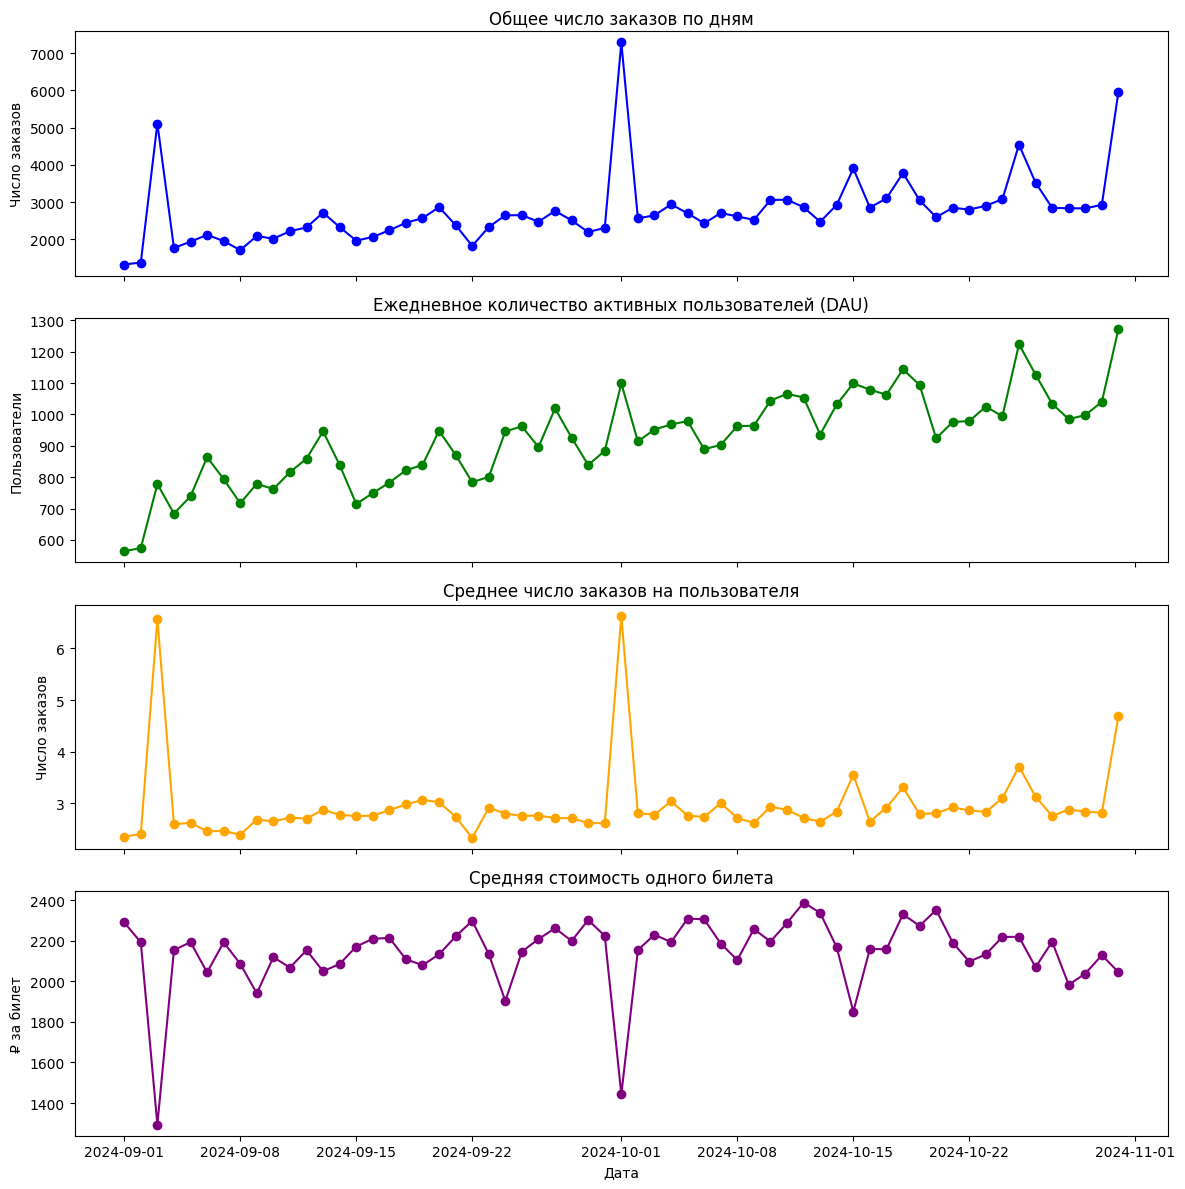

In [30]:

# Настройка графиков
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 1. Общее число заказов
axs[0].plot(daily_stats.index, daily_stats['orders_count'], marker='o', color='blue')
axs[0].set_title('Общее число заказов по дням')
axs[0].set_ylabel('Число заказов')

# 2. DAU — количество уникальных пользователей
axs[1].plot(daily_stats.index, daily_stats['dau'], marker='o', color='green')
axs[1].set_title('Ежедневное количество активных пользователей (DAU)')
axs[1].set_ylabel('Пользователи')

# 3. Среднее число заказов на пользователя
axs[2].plot(daily_stats.index, daily_stats['orders_per_user'], marker='o', color='orange')
axs[2].set_title('Среднее число заказов на пользователя')
axs[2].set_ylabel('Число заказов')

# 4. Средняя стоимость билета
axs[3].plot(daily_stats.index, daily_stats['avg_ticket_price'], marker='o', color='purple')
axs[3].set_title('Средняя стоимость одного билета')
axs[3].set_ylabel('₽ за билет')
axs[3].set_xlabel('Дата')

# Улучшение внешнего вида
plt.tight_layout()
plt.show()


In [31]:
# Добавляем столбец с днем недели
autumn_orders['weekday'] = autumn_orders['created_dt_msk'].dt.day_name()
# Группировка по дню недели
weekly_stats = autumn_orders.groupby('weekday').agg({
    'order_id': 'nunique',
    'user_id': 'nunique'
}).rename(columns={
    'order_id': 'orders_count',
    'user_id': 'dau'
}).reset_index()

# Добавляем признак будний или выходной
weekends = ['Saturday', 'Sunday']
weekly_stats['is_weekend'] = weekly_stats['weekday'].isin(weekends)
display(weekly_stats)

/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/1567381461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autumn_orders['weekday'] = autumn_orders['created_dt_msk'].dt.day_name()


,weekday,orders_count,dau,is_weekend
0,Friday,24804,4869,False
1,Monday,21504,4446,False
2,Saturday,21327,4569,True
3,Sunday,19383,4392,True
4,Thursday,27153,4969,False
5,Tuesday,31468,4793,False
6,Wednesday,22868,4811,False


/var/folders/6r/pctyynnx031885jxty11hjmr0000gn/T/ipykernel_7987/1724808923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_stats, x='is_weekend', y='dau', palette='Set1')


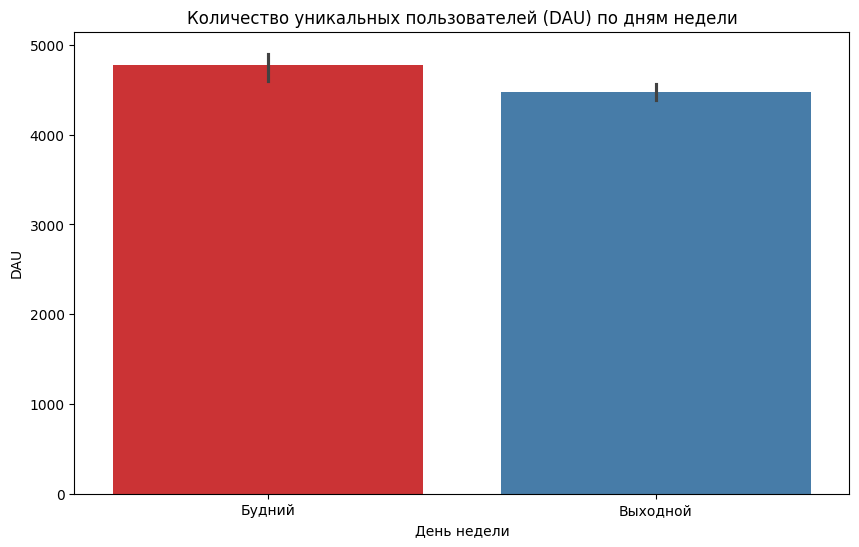

In [32]:
# Строим столбчатую диаграмму для количества заказов по дням недели
plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_stats, x='is_weekend', y='dau', palette='Set1')
plt.title('Количество уникальных пользователей (DAU) по дням недели')
plt.xlabel('День недели')
plt.ylabel('DAU')
plt.xticks(ticks=[0, 1], labels=['Будний', 'Выходной'])
plt.show()



1. **Распределение заказов по месяцам**:
    - Наблюдается рост количества заказов с июня по октябрь.
    - Пик активности приходится на октябрь, что может быть связано с увеличением числа мероприятий в осенний период.

2. **Распределение заказов по сезонам и категориям событий**:
    - С наступлением осени увеличивается доля заказов на концерты, театры и спортивные мероприятия.
    - Категория "ёлки" начинает набирать популярность, что связано с подготовкой к новогодним праздникам.
    - Доля заказов на выставки и другие мероприятия остается стабильной.

3. **Распределение заказов по устройствам**:
    - Большая часть заказов оформляется с мобильных устройств (около 80%).
    - Доля заказов с настольных устройств немного увеличивается осенью, что может быть связано с рабочей активностью пользователей.

4. **Распределение заказов по возрастным ограничениям**:
    - Наибольшая доля заказов приходится на мероприятия с возрастным ограничением 16+.
    - Осенью увеличивается доля заказов на мероприятия для детей (0+ и 6+), что может быть связано с началом учебного года и семейными мероприятиями.

5. **Изменение средней стоимости билетов**:
    - Средняя стоимость билетов на концерты и театры снижается осенью, что может быть связано с увеличением доступности мероприятий.
    - В то же время стоимость билетов на спортивные мероприятия и стендап-шоу возрастает.

6. **Осенняя активность пользователей**:
    - Наибольшее количество заказов приходится на будние дни, особенно на вторник и четверг.
    - В выходные дни активность пользователей снижается, но остается стабильной.
    - Средняя стоимость билета и количество заказов на пользователя варьируются в зависимости от дня недели.

### Общий вывод:
Осенью наблюдается рост активности пользователей, связанный с увеличением числа мероприятий и изменением предпочтений. Концерты, театры и спортивные события становятся более популярными, а стоимость билетов варьируется в зависимости от категории мероприятий. Пользователи чаще оформляют заказы с мобильных устройств, но доля заказов с настольных устройств также возрастает.

###  3.3.  Популярные события и партнёры

In [33]:
# Количество мероприятий и общее число заказов по регионам
region_stats = tickets_orders_cleaned.groupby('region_name').agg({
    'event_id': 'nunique',  
    'order_id': 'count'     
}).rename(columns={
    'event_id': 'events_count',
    'order_id': 'orders_count'
}).reset_index().sort_values(by='orders_count', ascending=False)
# Общие суммы по всем регионам
total_events = region_stats['events_count'].sum()
total_orders = region_stats['orders_count'].sum()

# Добавляем доли в процентах
region_stats['events_share'] = region_stats['events_count'] / total_events * 100
region_stats['orders_share'] = region_stats['orders_count'] / total_orders * 100

# Сортируем по количеству заказов
region_stats = region_stats.sort_values(by='orders_count', ascending=False)

display(region_stats.head())


,region_name,events_count,orders_count,events_share,orders_share
23,Каменевский регион,5933,89640,26.545861,31.174468
60,Североярская область,3797,43621,16.988814,15.170253
77,Широковская область,1232,16164,5.512304,5.621420
42,Медовская область,504,13890,2.255034,4.830582
45,Озернинский край,349,10346,1.561521,3.598071


In [34]:
# Для каждого партнера считаем количество мероприятийя, число заказов и выручку
partner_stats = tickets_orders_cleaned.groupby('organizers').agg({
    'event_id': 'nunique',
    'order_id': 'count',
    'revenue_rub': 'sum'
}).rename(columns={
    'event_id': 'events_count',
    'order_id': 'orders_count',
    'revenue_rub': 'total_revenue'
}).reset_index().sort_values(by='events_count', ascending=False)
display(partner_stats.head())

,organizers,events_count,orders_count,total_revenue
870,№1874,121,679,4088607.26
655,№1659,120,574,2353585.57
4012,№5024,117,878,10749666.71
734,№1738,117,1772,5060816.16
2523,№3529,113,1173,2590309.47




- **Лидеры среди регионов**:
    - Каменевский регион является явным лидером, занимая 31.87% всех заказов, что значительно превышает долю других регионов.
    - Североярская область занимает второе место с 15.43% заказов.
    - Остальные регионы, такие как Широковская область (5.76%) и Медовская область (4.87%), имеют заметно меньшую долю.

- **Лидеры среди партнёров**:
    - Среди партнёров выделяются организаторы с наибольшим количеством мероприятий и заказов. Например, партнёр №1874 провёл 121 мероприятие, собрав 681 заказов с общей выручкой 4.17 млн рублей.
    - Однако распределение заказов между партнёрами достаточно равномерное, без явного доминирования одного игрока.

### Общий вывод:
Рынок мероприятий демонстрирует концентрацию спроса на популярных категориях, таких как концерты и театры, а также в лидирующих регионах, таких как Каменевский регион. При этом партнёры имеют более равномерное распределение заказов, что может свидетельствовать о конкурентной среде.

## 4. Статистический анализ данных

In [ ]:
# Фильтруем данные для осеннего сезона
autumn_data = tickets_orders_cleaned[tickets_orders_cleaned['season'] == 'Осень']

# Группируем данные по пользователям и устройствам
user_device_stats = autumn_data.groupby(['user_id', 'device_type_canonical']).agg(
    orders_count=('order_id', 'count'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

# Разделяем данные на мобильные и стационарные устройства
mobile_users = user_device_stats[user_device_stats['device_type_canonical'] == 'mobile']
desktop_users = user_device_stats[user_device_stats['device_type_canonical'] == 'desktop']

alfa = 0.05

# Гипотеза 1: Среднее количество заказов на одного пользователя
t_stat_orders, p_value_orders = ttest_ind(
    mobile_users['orders_count'],
    desktop_users['orders_count'],
    alternative='greater'
)

# Гипотеза 2: Среднее время между заказами
t_stat_days, p_value_days = ttest_ind(
    mobile_users['avg_days_between_orders'].dropna(),
    desktop_users['avg_days_between_orders'].dropna(),
    alternative='greater'
)

# Вывод результатов
print("Гипотеза 1: Среднее количество заказов на одного пользователя")
print(f"t-статистика: {t_stat_orders:.2f}, p-значение: {p_value_orders:.4f}")

print("\nГипотеза 2: Среднее время между заказами")
print(f"t-статистика: {t_stat_days:.2f}, p-значение: {p_value_days:.4f}")

# Промежуточный вывод
if p_value_orders < alfa:
    print("\nГипотеза 1: Отвергаем нулевую гипотезу. Среднее количество заказов на одного пользователя мобильного приложения выше.")
else:
    print("\nГипотеза 1: Не удалось отвергнуть нулевую гипотезу. Нет статистически значимых различий.")

if p_value_days < alfa:
    print("Гипотеза 2: Отвергаем нулевую гипотезу. Среднее время между заказами пользователей мобильного приложения выше.")
else:
    print("Гипотеза 2: Не удалось отвергнуть нулевую гипотезу. Нет статистически значимых различий.")

Гипотеза 1: Среднее количество заказов на одного пользователя
t-статистика: 2.38, p-значение: 0.0087

Гипотеза 2: Среднее время между заказами
t-статистика: 11.68, p-значение: 0.0000

Гипотеза 1: Отвергаем нулевую гипотезу. Среднее количество заказов на одного пользователя мобильного приложения выше.
Гипотеза 2: Отвергаем нулевую гипотезу. Среднее время между заказами пользователей мобильного приложения выше.


## Общий вывод и рекомендации

### Информация о данных
В ходе анализа использовались три датасета:
1. **Заказы билетов** — информация о заказах, включая устройства, выручку, количество билетов и даты.
2. **События** — данные о мероприятиях, их типах, организаторах и регионах.
3. **Курс тенге к рублю** — данные о валютных курсах для пересчёта выручки.

### Основные результаты анализа
1. **Популярность мероприятий**:
    - Наиболее востребованными категориями являются **концерты** (37.6% заказов осенью) и **театры** (25.6% заказов осенью).
    - Осенью увеличилась доля заказов на **спорт** (+8.5%) и **ёлки** (+7.8%), что связано с сезонными особенностями.

2. **Средний чек**:
    - Средняя стоимость билета снизилась для **концертов** (-5.7%) и **театров** (-14.8%), но выросла для **спорта** (+18.1%) и **стендапа** (+14.8%).

3. **Пользовательская активность**:
    - Наибольшая активность наблюдается в будние дни, особенно во вторник и четверг.
    - Пользователи мобильных устройств оформляют больше заказов, чем пользователи стационарных устройств.

4. **Лидеры среди регионов и партнёров**:
    - **Каменевский регион** — лидер по числу заказов (31.9%) и выручке.
    - Среди партнёров выделяются организаторы с большим количеством мероприятий, например, партнёр №1874 (121 мероприятие, 4.17 млн рублей выручки).

### Проверка гипотез
1. **Среднее количество заказов на пользователя**:
    - Пользователи мобильных устройств оформляют больше заказов, чем пользователи стационарных устройств (p-value = 0.008).
2. **Среднее время между заказами**:
    - Пользователи стационарных устройств делают заказы реже, чем пользователи мобильных устройств (p-value ≈ 0).

### Рекомендации
1. **Оптимизация мероприятий**:
    - Увеличить количество мероприятий популярных категорий (концерты, театры, спорт) в осенний период.
    - Рассмотреть снижение цен на билеты для менее популярных категорий (выставки, стендап).

2. **Работа с регионами**:
    - Усилить маркетинг в регионах с низкой активностью, таких как Лесноярский край и Верхозёрский край.
    - Поддерживать высокий уровень мероприятий в Каменевском регионе.

3. **Пользовательский опыт**:
    - Продолжить развитие мобильного приложения, так как оно приносит больше заказов.
    - Упростить процесс оформления заказов для пользователей стационарных устройств.

4. **Работа с партнёрами**:
    - Сотрудничать с лидирующими партнёрами для увеличения числа мероприятий.
    - Анализировать эффективность партнёров с низкой выручкой и оптимизировать сотрудничество.

5. **Сезонные особенности**:
    - Увеличить количество мероприятий для детей (0+ и 6+) осенью, так как их популярность растёт.
    - Подготовить маркетинговые кампании для новогодних мероприятий (ёлки) заранее.